<h1>Create 4.5 Meter AWAC subset of data to validate methods against</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import signal
from scipy import interpolate
from scipy import optimize
from scipy import io
import cftime
import netCDF4 as nc
import pickle
import glob

In [2]:
class microSWIFT:
    def __init__(self, mission_dataset, microSWIFT_num):
        ''' '''
        # Get all variables from microSWIFT
        microSWIFT_nc_group = mission_dataset[microSWIFT_num]
        self.time = mission_dataset['time'][:]
        self.time_datetime = cftime.num2pydate(mission_dataset['time'][:], units=mission_dataset['time'].units, calendar=mission_dataset['time'].calendar)
        self.sampling_freq = mission_dataset['imu_freq'][:]

        # Define all measurements as variables of the microSWIFT class
        self.ax_body = microSWIFT_nc_group['accel_x'][:]
        self.ay_body = microSWIFT_nc_group['accel_y'][:]
        self.az_body = microSWIFT_nc_group['accel_z'][:] 
        self.gyro_x = microSWIFT_nc_group['gyro_x'][:]
        self.gyro_y = microSWIFT_nc_group['gyro_y'][:]
        self.gyro_z = microSWIFT_nc_group['gyro_z'][:]
        self.mag_x = microSWIFT_nc_group['mag_x'][:]
        self.mag_y = microSWIFT_nc_group['mag_y'][:]
        self.mag_z = microSWIFT_nc_group['mag_z'][:]
        self.x = microSWIFT_nc_group['xFRF'][:]
        self.y = microSWIFT_nc_group['yFRF'][:]
        self.z = microSWIFT_nc_group['gpsElevation'][:]
        self.u = microSWIFT_nc_group['u'][:]
        self.v = microSWIFT_nc_group['v'][:]

        # Linearly interolate to fill any nan values with an interpolated value
        accel_nans = np.isnan(self.ax_body)
        self.accel_nan_inds = accel_nans
        self.ax_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ax_body[~accel_nans])
        self.ay_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.ay_body[~accel_nans])
        self.az_body[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.az_body[~accel_nans])
        self.gyro_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_x[~accel_nans])
        self.gyro_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_y[~accel_nans])
        self.gyro_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.gyro_z[~accel_nans])
        self.mag_x[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_x[~accel_nans])
        self.mag_y[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_y[~accel_nans])
        self.mag_z[accel_nans] = np.interp(self.time[accel_nans], self.time[~accel_nans], self.mag_z[~accel_nans])

def transform2FRF(lat,lon):
    '''
    @edwinrainville, Originally written by J. Thomson, 1/2011

    Description: function to convert from lat & lon (decimal degrees, negative longitude) to FRF x,y (meters)
    '''

    # Define offsets
    lat_offset = 36.178039
    lon_offset = -75.749672

    # Define constants
    rotation = 19 #rotation in degress CCW from True north

    # Radius of Earth
    earth_rad = 6378.1 * 1000 # units are meters

    # correct radius for latitutde 
    radius_at_latoffset = earth_rad * np.cos(np.deg2rad(np.median(lat_offset))) 

    # Compute North-South and East-West Locations
    north = earth_rad * np.deg2rad(lat- lat_offset)
    east = radius_at_latoffset * np.deg2rad(lon_offset - lon) 

    # Rotate Coordinates by 19 degrees CCW from True north
    x = east * np.cos(np.deg2rad(rotation))   -   north * np.sin (np.deg2rad(rotation))
    x = -x # Flip x 
    y = east * np.sin(np.deg2rad(rotation))   +   north * np.cos (np.deg2rad(rotation))

    # return x and y values
    return x, y

In [3]:
# Functionalize finding the bathymetry to make it easy to call multiple times
def bathyAlongTrack(bathy_f, microSWIFT_of_interest):
    '''
    @ejrainville

    Linearly interpolates the bathymetry along the track of the microSWIFT.

    Parameters: bathy_f: interpolation class
                         an interpolation class set up by the bathymetry grid that takes in inputs of x and y location in the FRF coordinates and outputs the elevation 

                microSWIFT_of_interest: a microSWIFT class structure

    Returns: bathy_along_track: numpy array
                                An array of the interpolated bathymetry along the track of the microSWIFT

    '''
    bathy_along_track = []
    for n in np.arange(microSWIFT_of_interest.x.size):
        bathy_along_track.append(np.squeeze(bathy_f(microSWIFT_of_interest.x[n], microSWIFT_of_interest.y[n])).item())
    
    return bathy_along_track

def consecutive(data, stepsize=1):
    arrays = np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    size = 0
    ind_of_max = 0
    for n in np.arange(len(arrays)):
        if len(arrays[n]) > size:
            size = len(arrays[n])
            ind_of_max = n

    # Largest array
    largest_array = arrays[ind_of_max]
    return largest_array

def nearest_ind(items, pivot):
    time_diff = np.abs([date - pivot for date in items])
    return time_diff.argmin(0)

def nearAWACDict( time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_num, mission_num, E_awac, f_awac, Hs_awac, Tp_awac):
    data_dict = {'time':time_near_awac, 'microSWIFT_num':microSWIFT_num, 'mission_num':mission_num, 'bathy':bathy_near_awac, 'a_x':accel_x, 'a_y':accel_y, 'a_z':accel_z, 'gyro_x':gyro_x, 'gyro_y':gyro_y, 'gyro_z':gyro_z, 'mag_x':mag_x, 'mag_y':mag_y, 'mag_z':mag_z, 'x':x, 'y':y, 'u':u, 'v':v, 'E_awac':E_awac, 'f_awac':f_awac, 'Hs_awac':Hs_awac, 'Tp_awac':Tp_awac}
    return data_dict

In [4]:
# Data between 4-5 m subset
# Make a list of all missions
mission_list = glob.glob('../microSWIFT_data/cleanedDataset/mission_*.nc')
mission_list_subset = mission_list

# Bathymetry DEM
bathy_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc')
elevation_dem = bathy_data['elevation'][0,:,:]
bathy_xFRF = bathy_data['xFRF'][:]
bathy_yFRF = bathy_data['yFRF'][:]
bathy_f = interpolate.interp2d(bathy_xFRF, bathy_yFRF, elevation_dem)

# AWAC Data
awac_data = nc.Dataset('../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc')
awac_time = cftime.num2pydate(awac_data['time'][:], units=awac_data['time'].units, calendar=awac_data['time'].calendar)

# Loop through all missions to look at each microSWIFT
nearAWAC_list = []
nearAWACDataDict_list = []
counter = 0
for mission in mission_list_subset:
    # Print Progress
    print('Processed {} missions out of {} missions'.format(counter, len(mission_list_subset)))
    counter += 1
    # Make a dataset of the mission 
    mission_dataset = nc.Dataset(mission)

    # Make list of all micros in the mission
    microSWIFTs_on_mission = list(mission_dataset.groups.keys())

    # Loop through every microSWIFT in the mission
    for microSWIFT_of_interest_str in microSWIFTs_on_mission:
        microSWIFT_of_interest = microSWIFT(mission_dataset, microSWIFT_num=microSWIFT_of_interest_str)

        # Interpolate the Bathymetry grid along the microSWIFT track
        bathy_along_track = bathyAlongTrack(bathy_f, microSWIFT_of_interest)
        # Find all times when bathymetry is between 4 - 5 meters depth 
        inds_in_set = np.where((np.abs(bathy_along_track) > 4) & (np.abs(bathy_along_track) < 5))[0]

        # Find only consecutive values
        inds = consecutive(inds_in_set)

        # NOTE: usign 7400 points isntead of 7200 since 200 points are removed due to filtering 
        if len(inds) > 7400:
            # Get all variables for this subdataset
            time_near_awac = np.array([microSWIFT_of_interest.time_datetime[i] for i in inds])
            bathy_near_awac = np.array([bathy_along_track[i] for i in inds])
            accel_x = np.array([microSWIFT_of_interest.ax_body[i] for i in inds])
            accel_y = np.array([microSWIFT_of_interest.ay_body[i] for i in inds])
            accel_z = np.array([microSWIFT_of_interest.az_body[i] for i in inds])
            gyro_x = np.array([microSWIFT_of_interest.gyro_x[i] for i in inds])
            gyro_y = np.array([microSWIFT_of_interest.gyro_y[i] for i in inds])
            gyro_z = np.array([microSWIFT_of_interest.gyro_z[i] for i in inds])
            mag_x = np.array([microSWIFT_of_interest.mag_x[i] for i in inds])
            mag_y = np.array([microSWIFT_of_interest.mag_y[i] for i in inds])
            mag_z = np.array([microSWIFT_of_interest.mag_z[i] for i in inds])
            x = np.array([microSWIFT_of_interest.x[i] for i in inds])
            y = np.array([microSWIFT_of_interest.y[i] for i in inds])
            u = np.array([microSWIFT_of_interest.u[i] for i in inds])
            v = np.array([microSWIFT_of_interest.v[i] for i in inds])

            # Find 4.5 m AWAC aspectra at time closest to mission
            time_index = nearest_ind(awac_time, time_near_awac[-1])
            f_awac = awac_data['waveFrequency'][:]
            E_awac = awac_data['waveEnergyDensity'][time_index,:]
            Hs_awac = awac_data['waveHs'][time_index]
            Tp_awac = awac_data['waveTp'][time_index]

            # Save this data into a nearAWACData strucuture and append to nearAWAC list
            nearAWACDataDict_list.append(nearAWACDict( time_near_awac, bathy_near_awac, accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, x, y, u, v, microSWIFT_of_interest_str, mission, E_awac, f_awac, Hs_awac, Tp_awac))

        else:
            continue



Processed 0 missions out of 74 missions
Processed 1 missions out of 74 missions
Processed 2 missions out of 74 missions
Processed 3 missions out of 74 missions
Processed 4 missions out of 74 missions
Processed 5 missions out of 74 missions
Processed 6 missions out of 74 missions
Processed 7 missions out of 74 missions
Processed 8 missions out of 74 missions
Processed 9 missions out of 74 missions
Processed 10 missions out of 74 missions
Processed 11 missions out of 74 missions
Processed 12 missions out of 74 missions
Processed 13 missions out of 74 missions
Processed 14 missions out of 74 missions
Processed 15 missions out of 74 missions
Processed 16 missions out of 74 missions
Processed 17 missions out of 74 missions
Processed 18 missions out of 74 missions
Processed 19 missions out of 74 missions
Processed 20 missions out of 74 missions
Processed 21 missions out of 74 missions
Processed 22 missions out of 74 missions
Processed 23 missions out of 74 missions
Processed 24 missions out 

KeyboardInterrupt: 

<h2>Look through each subset of data to make sure it looks ok</h2>

/var/folders/yq/nm8v_c9d4_dbks_1kbmx542r0000gp/T/ipykernel_91387/1685559960.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))


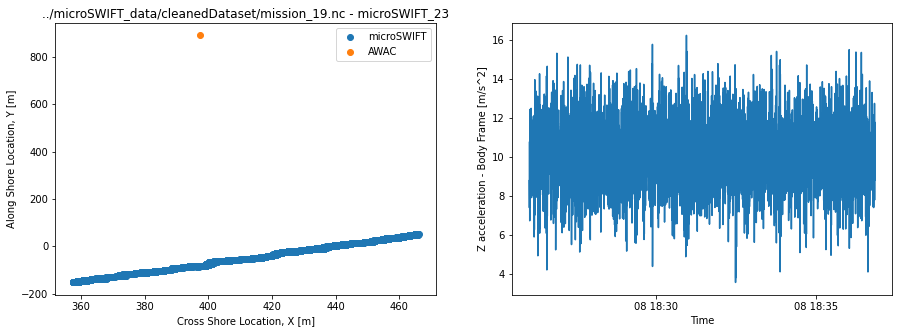

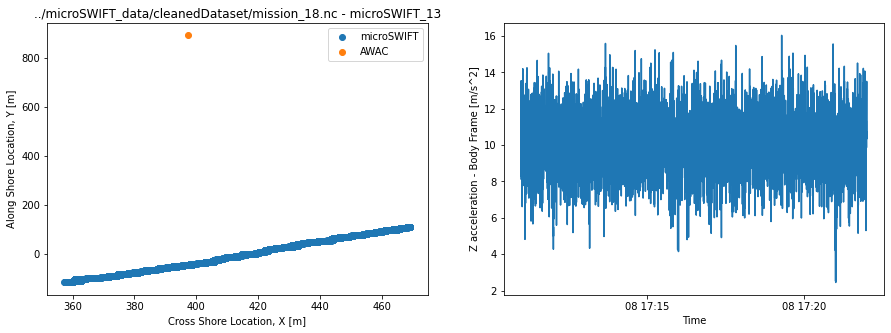

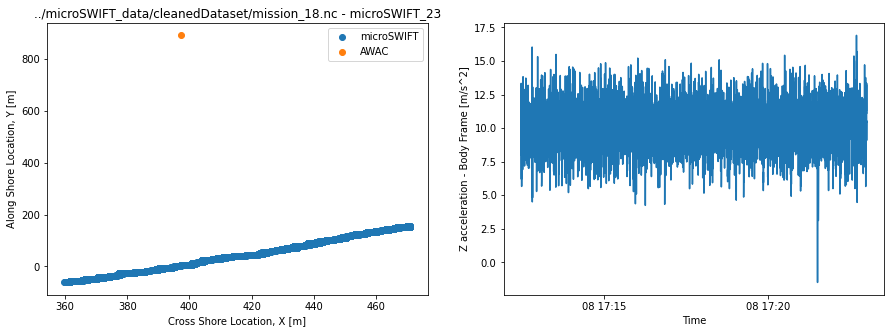

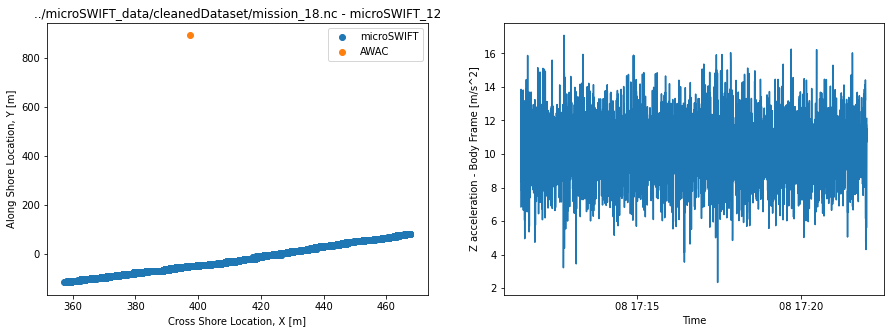

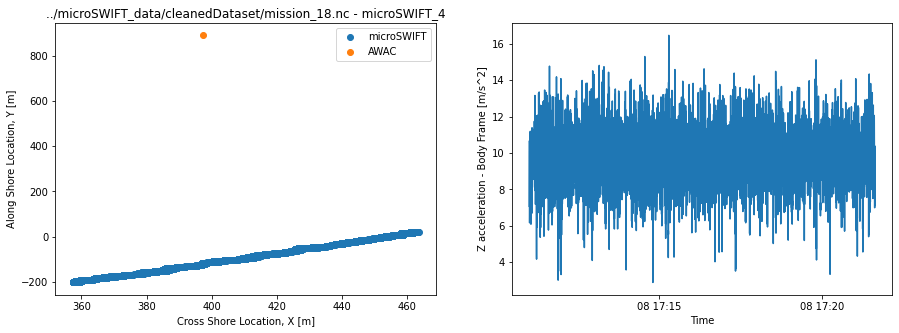

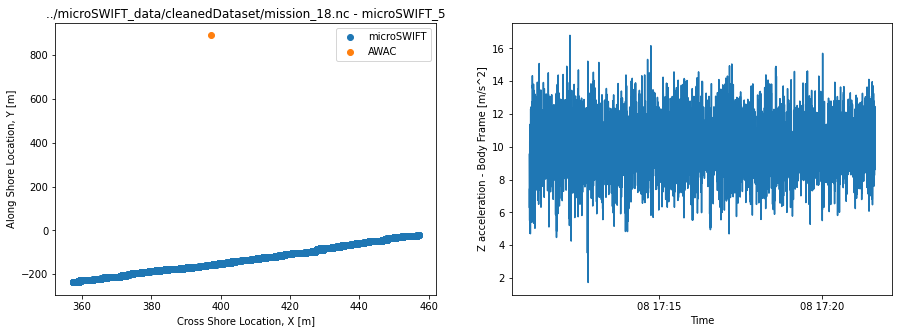

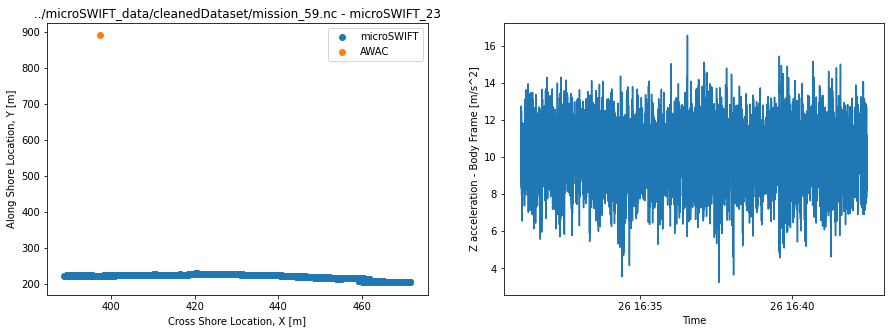

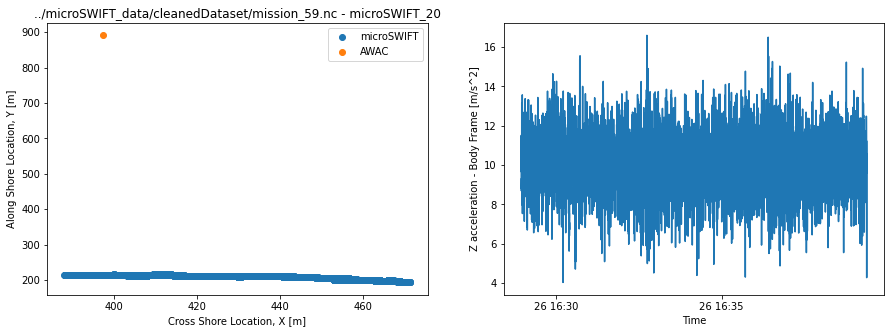

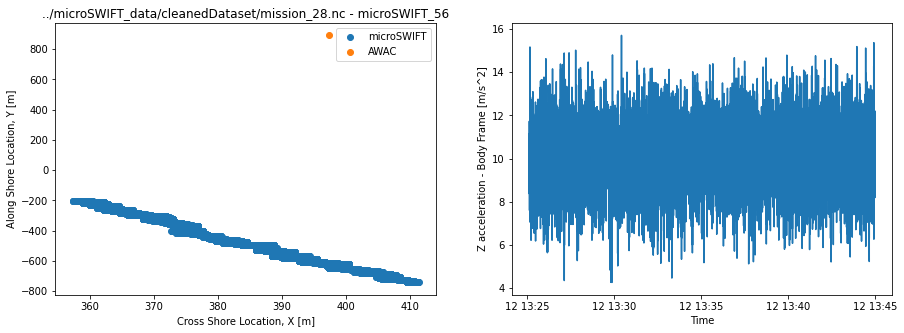

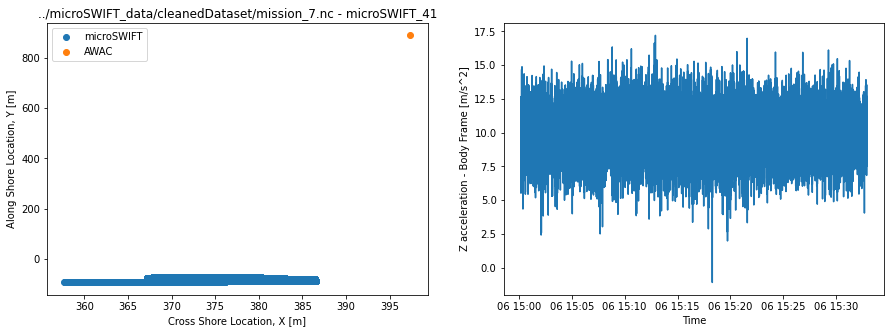

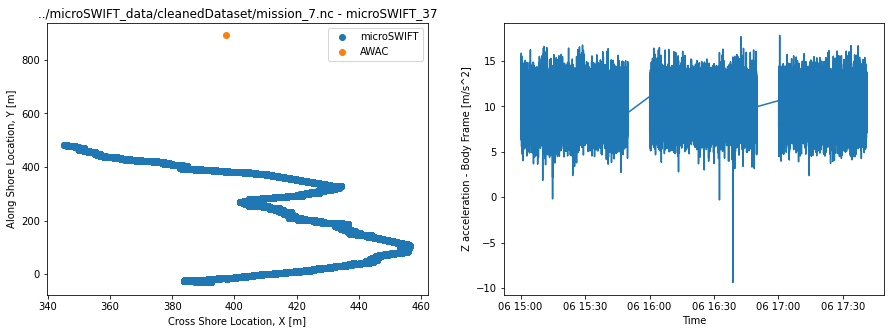

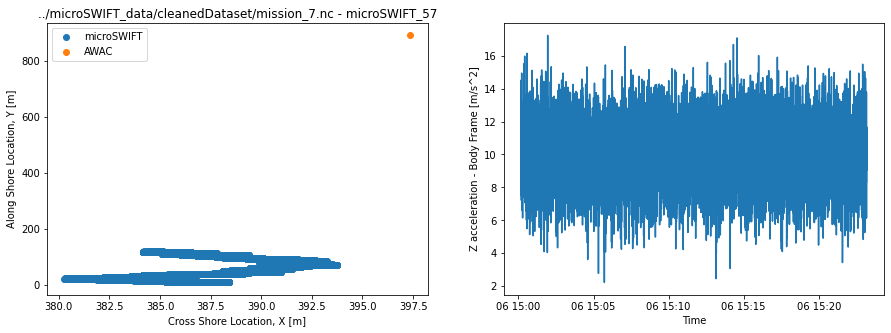

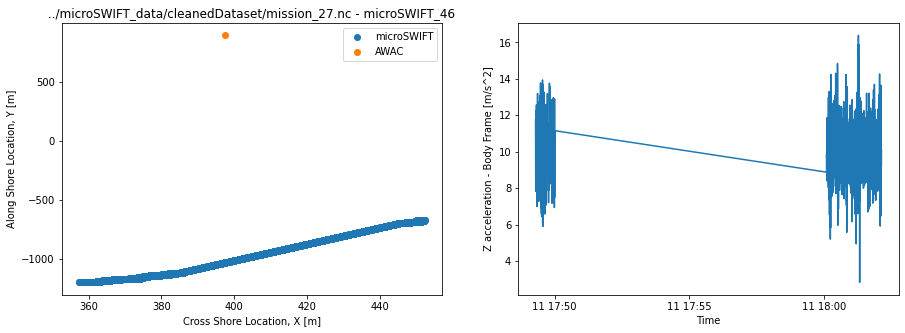

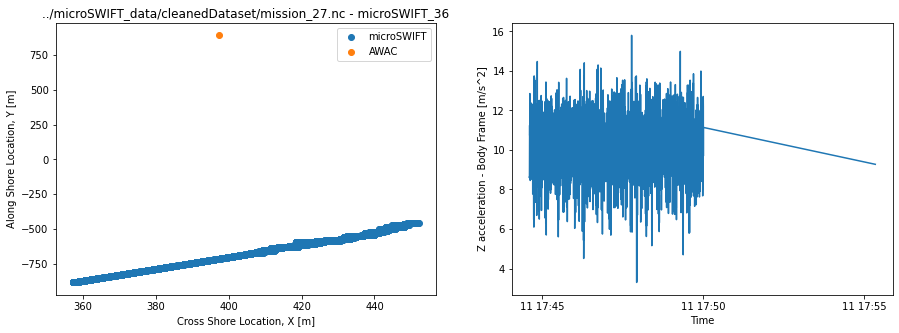

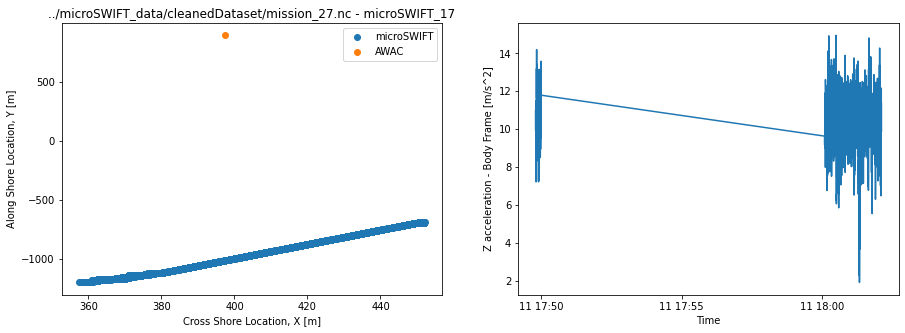

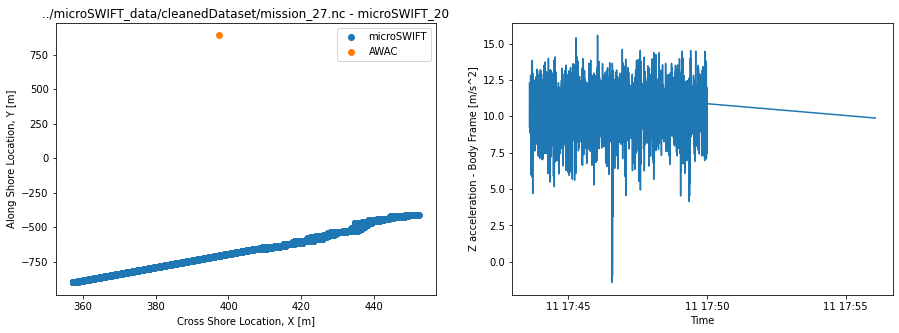

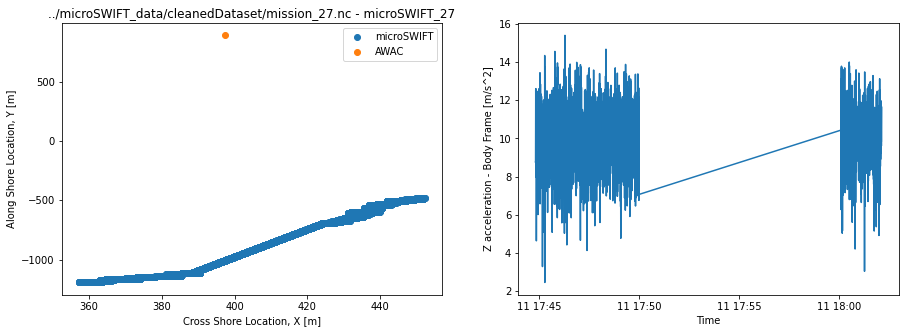

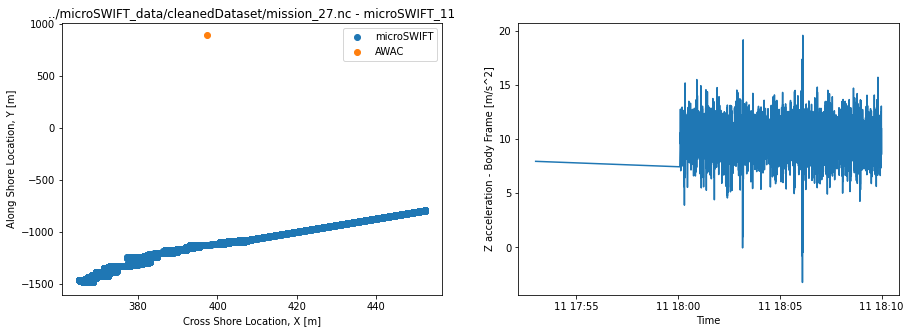

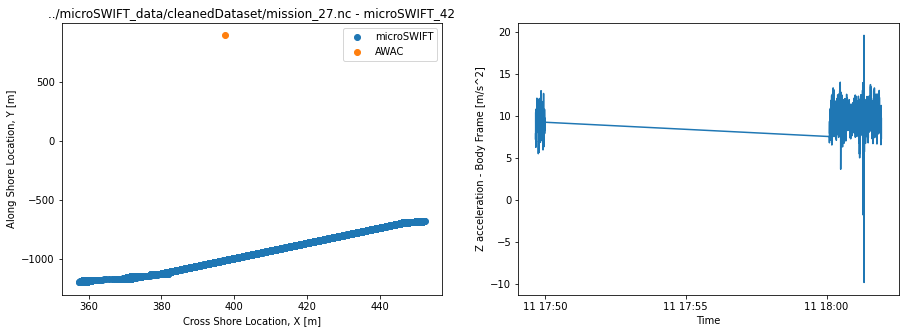

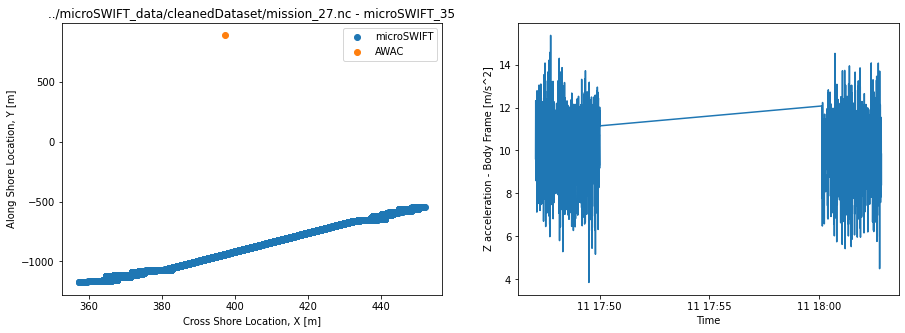

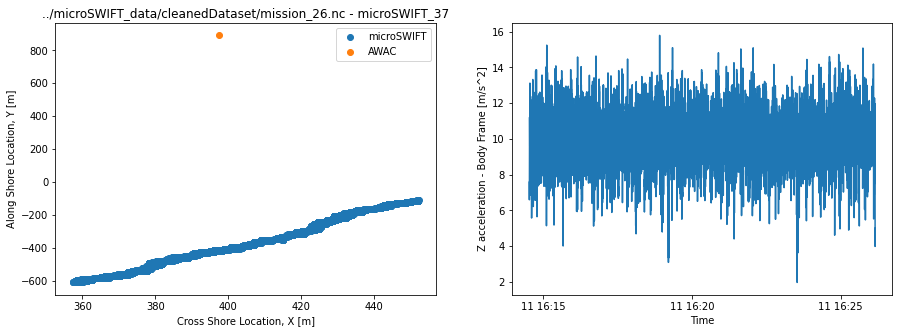

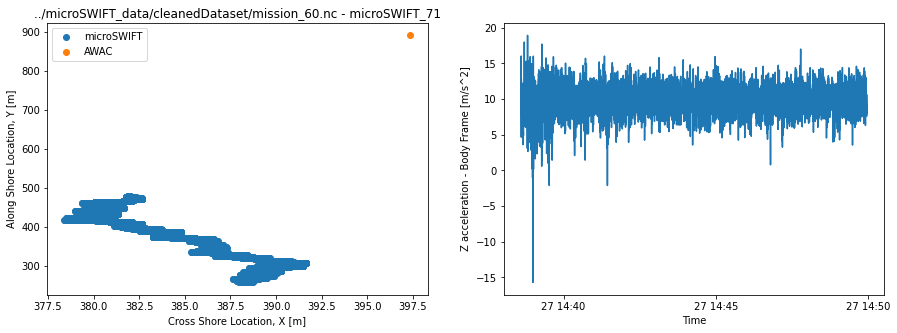

In [ ]:
# Plot Track and Accelerations for each subset
def plotSubset(subsetDict):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    # microSWIFT Track
    ax1.scatter(subsetDict['x'], subsetDict['y'], label='microSWIFT')
    xFRF_awac, yFRF_awac = transform2FRF(np.float64(awac_data['latitude'][:]), np.float64(awac_data['longitude'][:]))
    ax1.scatter(xFRF_awac, yFRF_awac, label='AWAC')
    ax1.set_title('{} - {}'.format(subsetDict['mission_num'], subsetDict['microSWIFT_num']))
    ax1.legend()
    ax1.set_xlabel('Cross Shore Location, X [m]')
    ax1.set_ylabel('Along Shore Location, Y [m]')
    
    # microSWIFT Acceleration
    ax2.plot(subsetDict['time'], subsetDict['a_z'])
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Z acceleration - Body Frame [m/s^2]')

    # Save the figure 
    fig.savefig('./figures/Mission{}_{}.png'.format(subsetDict['mission_num'][-5:-3], subsetDict['microSWIFT_num']))

# Plot the tracks and accelerations
for subset in nearAWACDataDict_list:
    plotSubset(subset)

In [ ]:
# Remove Datasets that have large gaps in them for analysis now
datasets_to_save = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 20, 21]

# Save the data dictionaries as mat files
for subset_num in datasets_to_save:
    subset = nearAWACDataDict_list[subset_num]
    io.savemat('./data/nearAWACData_mission{}_{}.mat'.format(subset['mission_num'][-5:-3], subset['microSWIFT_num']), subset)